<a href="https://colab.research.google.com/github/vin136/A-look-into-Netflix-Challenge-Making-better-recommendations/blob/master/data(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
from google.colab import files

In [59]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [60]:
stock_dir = '/content/gdrive/MyDrive/stock_data/'
ticker_dir = '/content/gdrive/MyDrive/tickers/'
import pandas as pd
df_t = pd.read_csv(ticker_dir+'tickers.csv')


In [61]:
df_t[df_t['filter'] == 3704].groupby('ctryId').count()

,ticker,filter
ctryId,,
1,163,163
2,37,37


In [62]:
df_t_filtered = (df_t[(df_t['filter'] == 3704) & (df_t['ctryId'] == 2)]).copy()

In [63]:
tickers = df_t_filtered['ticker'].unique()
sector_info = ['ind1','ind2','ind3']
from collections import defaultdict
sector_map = defaultdict(list)
for ticker in tickers:
  df = pd.read_parquet(base_dir+f'{ticker}.parquet')
  s = df[sector_info].iloc[0].values
  sector_map[f'{str(s[0])}_{str(s[1])}_{str(s[2])}'].append(ticker)





In [64]:
sample_sector = sorted(sector_map.items(),reverse=True,key = lambda x:len(x[1]))[0][0]

In [65]:
sl = sector_map[sample_sector]


In [92]:
import copy
use_cols = ['adjSplClo','adv30','ret']
concat_dfs = []
for id in sl:
  df = pd.read_parquet(base_dir+f'{id}.parquet')
  df.index = df['date']
  df = copy.deepcopy(df[use_cols])
  new_cols = [id+'_'+col for col in df.columns]
  orig_cols = df.columns
  df = df.rename(dict(zip(orig_cols,new_cols)),axis=1)
  concat_dfs.append(copy.deepcopy(df))
  
sector_df = pd.concat(concat_dfs,axis=1,join="inner")


In [94]:
#sector_df.to_parquet(ticker_dir+'sector_df')

In [96]:
sector_df = pd.read_parquet(ticker_dir+'sector_df')

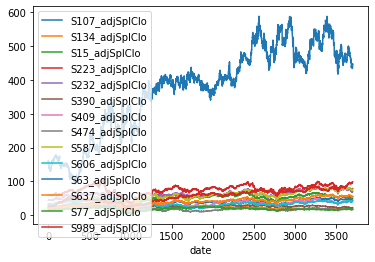

In [105]:
sector_df[[col for col in sector_df.columns if ('adjSplClo' in col)]].plot()

In [106]:
sector_df.head(2)

,S107_adjSplClo,S107_adv30,S107_ret,S134_adjSplClo,S134_adv30,S134_ret,S15_adjSplClo,S15_adv30,S15_ret,S223_adjSplClo,S223_adv30,S223_ret,S232_adjSplClo,S232_adv30,S232_ret,S390_adjSplClo,S390_adv30,S390_ret,S409_adjSplClo,S409_adv30,S409_ret,S474_adjSplClo,S474_adv30,S474_ret,S587_adjSplClo,S587_adv30,S587_ret,S606_adjSplClo,S606_adv30,S606_ret,S63_adjSplClo,S63_adv30,S63_ret,S637_adjSplClo,S637_adv30,S637_ret,S77_adjSplClo,S77_adv30,S77_ret,S989_adjSplClo,S989_adv30,S989_ret
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,21.292837,2.291811e+07,-0.008229,14.628039,6.155731e+06,-0.002801,32.707638,5.574250e+07,0.000000,58.553249,5.662435e+07,0.001406,43.801941,5.375940e+07,-0.000188,22.188601,9.755497e+06,-0.004424,23.174761,2.626477e+06,-0.000886,23.639076,6.900214e+07,0.002090,29.913521,7.562272e+07,-0.002740,31.729698,4.086789e+07,-0.001035,161.590530,2.245087e+06,0.000815,20.236824,7.545287e+07,-0.002026,14.825273,2.403738e+06,0.013483,26.379778,4.931781e+06,-0.004651
2.0,21.117741,2.195108e+07,-0.003860,14.269408,6.249682e+06,-0.020225,32.523449,5.713870e+07,-0.001257,58.337662,5.662435e+07,0.000702,44.223709,5.437781e+07,0.014071,22.140491,1.016122e+07,0.002222,23.298244,2.583656e+06,0.009752,23.425066,6.900214e+07,-0.004693,29.680206,7.562272e+07,-0.003434,32.040710,4.086789e+07,0.014245,157.135315,2.122260e+06,-0.023293,20.176811,7.545287e+07,0.001421,14.367592,2.447285e+06,-0.026608,26.755140,4.931781e+06,0.018692


## Preprocessing

Approach 1:
Use simple features but with a highly-non-linear modeling(tree based models, neural networks). Here,modeling part takes care of extracting and combining features optimally.

Approach 2:
Use a simple model but figure out optimal features(manual or following statistical procedures). 

Approach 2 is both time consuming and likely need further intution about the data.

Below I follow modeling through `Approach 1` based methods.

1. Using commonly used technical indicators for modeling.

### Indicators

In [113]:
#indicator.py
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
EPS = np.finfo(float).eps
class TA:
    @classmethod
    def SMA(cls, ohlc: DataFrame, period: int = 41, column: str = "close") -> Series:
        """
        Simple moving average - rolling mean in pandas lingo. Also known as 'MA'.
        The simple moving average (SMA) is the most basic of the moving averages used for trading.
        """

        return pd.Series(
            ohlc[column]
            .rolling(center=False, window=period, min_periods=period - 1)
            .mean(),
            name="{0} period SMA".format(period),
        )

    @classmethod
    def EMA(cls, ohlc: DataFrame, period: int = 9, column: str = "close") -> Series:
        """
        Exponential Weighted Moving Average - Like all moving average indicators, they are much better suited for trending markets.
        When the market is in a strong and sustained uptrend, the EMA indicator line will also show an uptrend and vice-versa for a down trend.
        EMAs are commonly used in conjunction with other indicators to confirm significant market moves and to gauge their validity.
        """

        return pd.Series(
            ohlc[column]
            .ewm(ignore_na=False, min_periods=period - 1, span=period)
            .mean(),
            name="{0} period EMA".format(period),
        )
    

    @classmethod
    def TRIMA(cls, ohlc: DataFrame, period: int = 18) -> Series:
        """
        The Triangular Moving Average (TRIMA) [also known as TMA] represents an average of prices,
        but places weight on the middle prices of the time period.
        The calculations double-smooth the data using a window width that is one-half the length of the series.
        source: https://www.thebalance.com/triangular-moving-average-tma-description-and-uses-1031203
        """

        SMA = cls.SMA(ohlc, period).rolling(window=period).sum()
        return pd.Series(SMA / period, name="{0} period TRIMA".format(period))

    @classmethod
    def TEMA(cls, ohlc: DataFrame, period: int = 9) -> Series:
        """
        Triple exponential moving average - attempts to remove the inherent lag associated to Moving Averages by placing more weight on recent values.
        The name suggests this is achieved by applying a triple exponential smoothing which is not the case. The name triple comes from the fact that the
        value of an EMA (Exponential Moving Average) is triple.
        To keep it in line with the actual data and to remove the lag the value 'EMA of EMA' is subtracted 3 times from the previously tripled EMA.
        Finally 'EMA of EMA of EMA' is added.
        Because EMA(EMA(EMA)) is used in the calculation, TEMA needs 3 * period - 2 samples to start producing values in contrast to the period samples
        needed by a regular EMA.
        """

        triple_ema = 3 * cls.EMA(ohlc, period)
        ema_ema_ema = (
            cls.EMA(ohlc, period)
            .ewm(ignore_na=False, span=period)
            .mean()
            .ewm(ignore_na=False, span=period)
            .mean()
        )

        TEMA = (
            triple_ema
            - 3
            * cls.EMA(ohlc, period)
            .ewm(span=period)
            .mean()
            + ema_ema_ema
        )
        return pd.Series(TEMA, name="{0} period TEMA".format(period))
   
    @classmethod
    def ER(cls, ohlc: DataFrame, period: int = 10) -> Series:
        """The Kaufman Efficiency indicator is an oscillator indicator that oscillates between +100 and -100, where zero is the center point.
         +100 is upward forex trending market and -100 is downwards trending markets."""

        change = ohlc["close"].diff(period).abs()
        volatility = ohlc["close"].diff().abs().rolling(window=period).sum()

        return pd.Series(change / volatility, name="{0} period ER".format(period))
   
    @classmethod
    def DEMA(cls, ohlc: DataFrame, period: int = 9, column: str = "close") -> Series:
        """
        Double Exponential Moving Average - attempts to remove the inherent lag associated to Moving Averages
         by placing more weight on recent values. The name suggests this is achieved by applying a double exponential
        smoothing which is not the case. The name double comes from the fact that the value of an EMA (Exponential Moving Average) is doubled.
        To keep it in line with the actual data and to remove the lag the value 'EMA of EMA' is subtracted from the previously doubled EMA.
        Because EMA(EMA) is used in the calculation, DEMA needs 2 * period -1 samples to start producing values in contrast to the period
        samples needed by a regular EMA
        """

        DEMA = (
            2 * cls.EMA(ohlc, period)
            - cls.EMA(ohlc, period)
            .ewm(span=period)
            .mean()
        )

        return pd.Series(DEMA, name="{0} period DEMA".format(period))


    @classmethod
    def MACD(
        cls,
        ohlc: DataFrame,
        period_fast: int = 12,
        period_slow: int = 26,
        signal: int = 9,
    ) -> Series:
        """
        MACD, MACD Signal and MACD difference.
        The MACD Line oscillates above and below the zero line, which is also known as the centerline.
        These crossovers signal that the 12-day EMA has crossed the 26-day EMA. The direction, of course, depends on the direction of the moving average cross.
        Positive MACD indicates that the 12-day EMA is above the 26-day EMA. Positive values increase as the shorter EMA diverges further from the longer EMA.
        This means upside momentum is increasing. Negative MACD values indicates that the 12-day EMA is below the 26-day EMA.
        Negative values increase as the shorter EMA diverges further below the longer EMA. This means downside momentum is increasing.

        Signal line crossovers are the most common MACD signals. The signal line is a 9-day EMA of the MACD Line.
        As a moving average of the indicator, it trails the MACD and makes it easier to spot MACD turns.
        A bullish crossover occurs when the MACD turns up and crosses above the signal line.
        A bearish crossover occurs when the MACD turns down and crosses below the signal line.
        """

        EMA_fast = pd.Series(
            ohlc["close"]
            .ewm(ignore_na=False, min_periods=period_slow - 1, span=period_fast)
            .mean(),
            name="EMA_fast",
        )
        EMA_slow = pd.Series(
            ohlc["close"]
            .ewm(ignore_na=False, min_periods=period_slow - 1, span=period_slow)
            .mean(),
            name="EMA_slow",
        )
        MACD = pd.Series(EMA_fast - EMA_slow, name="MACD")
        MACD_signal = pd.Series(
            MACD.ewm(ignore_na=False, span=signal).mean(), name="SIGNAL"
        )

        return pd.concat([MACD, MACD_signal], axis=1)

    @classmethod
    def ROC(cls, ohlc: DataFrame, period: int = 12) -> Series:
        """The Rate-of-Change (ROC) indicator, which is also referred to as simply Momentum,
        is a pure momentum oscillator that measures the percent change in price from one period to the next.
        The ROC calculation compares the current price with the price “n” periods ago."""

        return pd.Series(
            (ohlc["close"].diff(period) / ohlc["close"].shift(period)) * 100, name="ROC"
        )

    @classmethod
    def RSI(cls, ohlc: DataFrame, period: int = 14) -> Series:
        """Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements.
        RSI oscillates between zero and 100. Traditionally, and according to Wilder, RSI is considered overbought when above 70 and oversold when below 30.
        Signals can also be generated by looking for divergences, failure swings and centerline crossovers.
        RSI can also be used to identify the general trend."""

        ## get the price diff
        delta = ohlc["close"].diff()

        ## positive gains (up) and negative gains (down) Series
        up, down = delta.copy(), delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0

        # EMAs of ups and downs
        _gain = up.ewm(span=period, min_periods=period - 1).mean()
        _loss = down.abs().ewm(span=period, min_periods=period - 1).mean()

        RS = (_gain + EPS) / (_loss + EPS)
        return pd.Series(100 - (100 / (1 + RS)), name="RSI")

    @classmethod
    def TR(cls, ohlc: DataFrame) -> Series:
        """True Range is the maximum of three price ranges.
        Most recent period's high minus the most recent period's low.
        Absolute value of the most recent period's high minus the previous close.
        Absolute value of the most recent period's low minus the previous close."""

        TR1 = pd.Series(ohlc["high"] - ohlc["low"]).abs()  # True Range = High less Low

        TR2 = pd.Series(
            ohlc["high"] - ohlc["close"].shift()
        ).abs()  # True Range = High less Previous Close

        TR3 = pd.Series(
            ohlc["close"].shift() - ohlc["low"]
        ).abs()  # True Range = Previous Close less Low

        _TR = pd.concat([TR1, TR2, TR3], axis=1)

        _TR["TR"] = _TR.max(axis=1)

        return pd.Series(_TR["TR"], name="TR")

    @classmethod
    def ATR(cls, ohlc: DataFrame, period: int = 14) -> Series:
        """Average True Range is moving average of True Range."""

        TR = cls.TR(ohlc)
        return pd.Series(
            TR.rolling(center=False, window=period, min_periods=period - 1).mean(),
            name="{0} period ATR".format(period),
        )

    @classmethod
    def PEAKMINUSTROUGH(cls, ohlc: DataFrame, period: int = 14) -> Series:
        """PEAK_To_Trough over a period"""
        highest_high = ohlc["high"].rolling(center=False, window=period).max()
        lowest_low = ohlc["low"].rolling(center=False, window=period).min()
        PEAKMINUSTROUGH = pd.Series(
            (highest_high - lowest_low),
            name="{0} period PEAKMINUSTROUGH".format(period),
        )
        return PEAKMINUSTROUGH

    @classmethod
    def PEAKMINUSTROUGHCLOSE(cls, ohlc: DataFrame, period: int = 14) -> Series:
        """PEAK_To_Trough over a period"""
        highest_high = ohlc["close"].rolling(center=False, window=period).max()
        lowest_low = ohlc["close"].rolling(center=False, window=period).min()
        PEAKMINUSTROUGHCLOSE = pd.Series(
            (highest_high - lowest_low),
            name="{0} period PEAKMINUSTROUGHCLOSE".format(period),
        )
        return PEAKMINUSTROUGHCLOSE

    @classmethod
    def PRICESTD(cls, ohlc: DataFrame, period: int = 14) -> Series:
        """Price std over a period"""
        return pd.Series( ohlc["close"].rolling(window=period).std() ,
                        name="{0} Price STD".format(period),
                        )

    
    @classmethod
    def BBANDS(
        cls, ohlc: DataFrame, period: int = 20, MA: Series = None, column: str = "close"
    ) -> Series:
        """
         Developed by John Bollinger, Bollinger Bands® are volatility bands placed above and below a moving average.
         Volatility is based on the standard deviation, which changes as volatility increases and decreases.
         The bands automatically widen when volatility increases and narrow when volatility decreases.

         This method allows input of some other form of moving average like EMA or KAMA around which BBAND will be formed.
         Pass desired moving average as <MA> argument. For example BBANDS(MA=TA.KAMA(20)).
         """

        std = ohlc["close"].rolling(window=period).std()

        if not isinstance(MA, pd.core.series.Series):
            middle_band = pd.Series(cls.SMA(ohlc, period), name="BB_MIDDLE")
        else:
            middle_band = pd.Series(MA, name="BB_MIDDLE")

        upper_bb = pd.Series(middle_band + (2 * std), name="BB_UPPER")
        lower_bb = pd.Series(middle_band - (2 * std), name="BB_LOWER")

        return pd.concat([upper_bb, middle_band, lower_bb], axis=1)
    
    @classmethod
    def BBANDSSTDDIST(
        cls, ohlc: DataFrame, period: int = 20, MA: Series = None, column: str = "close"
    ) -> Series:
        """
         Developed by John Bollinger, Bollinger Bands® are volatility bands placed above and below a moving average.
         Volatility is based on the standard deviation, which changes as volatility increases and decreases.
         The bands automatically widen when volatility increases and narrow when volatility decreases.

         This method allows input of some other form of moving average like EMA or KAMA around which BBAND will be formed.
         Pass desired moving average as <MA> argument. For example BBANDS(MA=TA.KAMA(20)).
         """

        std = ohlc["close"].rolling(window=period).std() + EPS

        if not isinstance(MA, pd.core.series.Series):
            middle_band = pd.Series(cls.SMA(ohlc, period), name="BB_MIDDLE")
        else:
            middle_band = pd.Series(MA, name="BB_MIDDLE")
        diff = (ohlc["close"] - middle_band)
        diff[diff.abs()<1e-6] = 0. # tho this thresh can be even high, just being safe from round issues

        bb_dist =pd.Series( (diff).divide(std), name="BB_DIST")
        return bb_dist

    @classmethod
    def TURNOVR(cls, ohlcv: DataFrame, period: int = 30) -> Series:
        return pd.Series(
            (ohlcv["close"] * ohlcv["volume"]).rolling(period).sum(), name="TURNOVR"
        )

    @classmethod
    def KC(
        cls, ohlc: DataFrame, period: int = 20, atr_period: int = 10, MA: Series = None
    ) -> Series:
        """Keltner Channels [KC] are volatility-based envelopes set above and below an exponential moving average.
        This indicator is similar to Bollinger Bands, which use the standard deviation to set the bands.
        Instead of using the standard deviation, Keltner Channels use the Average True Range (ATR) to set channel distance.
        The channels are typically set two Average True Range values above and below the 20-day EMA.
        The exponential moving average dictates direction and the Average True Range sets channel width.
        Keltner Channels are a trend following indicator used to identify reversals with channel breakouts and channel direction.
        Channels can also be used to identify overbought and oversold levels when the trend is flat."""

        if not isinstance(MA, pd.core.series.Series):
            middle = pd.Series(cls.EMA(ohlc, period), name="KC_MIDDLE")
        else:
            middle = pd.Series(MA, name="KC_MIDDLE")

        up = pd.Series(middle + (2 * cls.ATR(ohlc, atr_period)), name="KC_UPPER")
        down = pd.Series(middle - (2 * cls.ATR(ohlc, atr_period)), name="KC_LOWER")

        return pd.concat([up, down], axis=1)

    @classmethod
    def DMI(cls, ohlc: DataFrame, period: int = 14) -> Series:
        """The directional movement indicator (also known as the directional movement index - DMI) is a valuable tool
         for assessing price direction and strength. This indicator was created in 1978 by J. Welles Wilder, who also created the popular
         relative strength index. DMI tells you when to be long or short.
         It is especially useful for trend trading strategies because it differentiates between strong and weak trends,
         allowing the trader to enter only the strongest trends.
        """

        ohlc["up_move"] = ohlc["high"].diff()
        ohlc["down_move"] = -ohlc["low"].diff()

        DMp = []
        DMm = []

        for row in ohlc.itertuples():
            if row.up_move > row.down_move and row.up_move > 0:
                DMp.append(row.up_move)
            else:
                DMp.append(0)

            if row.down_move > row.up_move and row.down_move > 0:
                DMm.append(row.down_move)
            else:
                DMm.append(0)

        ohlc["DMp"] = DMp
        ohlc["DMm"] = DMm

        diplus = pd.Series(
            100
            * (ohlc["DMp"] / cls.ATR(ohlc, period))
            .ewm(span=period, min_periods=period - 1)
            .mean(),
            name="DI+",
        )
        diminus = pd.Series(
            100
            * (ohlc["DMm"] / cls.ATR(ohlc, period))
            .ewm(span=period, min_periods=period - 1)
            .mean(),
            name="DI-",
        )

        return pd.concat([diplus, diminus], axis=1)

    @classmethod
    def ADX(cls, ohlc: DataFrame, period: int = 14) -> Series:
        """The A.D.X. is 100 * smoothed moving average of absolute value (DMI +/-) divided by (DMI+ + DMI-). ADX does not indicate trend direction or momentum,
        only trend strength. Generally, A.D.X. readings below 20 indicate trend weakness,
        and readings above 40 indicate trend strength. An extremely strong trend is indicated by readings above 50"""

        dmi = cls.DMI(ohlc, period)
        return pd.Series(
            100
            * (abs(dmi["DI+"] - dmi["DI-"]) / (dmi["DI+"] + dmi["DI-"] + 1e-6))
            .ewm(alpha=1 / period)
            .mean(),
            name="{0} period ADX.".format(period),
        )

    @classmethod
    def REGIMESMA(cls, ohlc: DataFrame, period: int = 14) -> Series:
        return pd.Series(cls.SMA(ohlc.shift(1), period), name="REGIMESMA")

    @classmethod
    def REGIMESTOCH(cls, ohlc: DataFrame, period: int = 14) -> Series:
        max_close = pd.Series(ohlc["close"].shift(1).rolling(center=False, window=period).max(), name = "MAXCLOSE")
        min_close = pd.Series(ohlc["close"].shift(1).rolling(center=False, window=period).min(), name = "MINCLOSE")
        return pd.concat([max_close, min_close], axis=1)

       
    @classmethod
    def STOCH(cls, ohlc: DataFrame, period: int = 14) -> Series:
        """Stochastic oscillator %K
         The stochastic oscillator is a momentum indicator comparing the closing price of a security
         to the range of its prices over a certain period of time.
         The sensitivity of the oscillator to market movements is reducible by adjusting that time
         period or by taking a moving average of the result.
        """

        highest_high = ohlc["high"].rolling(center=False, window=period).max()
        lowest_low = ohlc["low"].rolling(center=False, window=period).min()

        STOCH = pd.Series(
            (ohlc["close"] - lowest_low + EPS) / (highest_high - lowest_low + 2* EPS),
            name="{0} period STOCH %K".format(period),
        )

        return 100 * STOCH

    @classmethod
    def STOCHCLOSE(cls, ohlc: DataFrame, period: int = 14) -> Series:
        """Stochastic oscillator %K
         The stochastic oscillator is a momentum indicator comparing the closing price of a security
         to the range of its prices over a certain period of time.
         The sensitivity of the oscillator to market movements is reducible by adjusting that time
         period or by taking a moving average of the result.
        """

        highest_high = ohlc["close"].rolling(center=False, window=period).max()
        lowest_low = ohlc["close"].rolling(center=False, window=period).min()

        STOCH = pd.Series(
            (ohlc["close"] - lowest_low + EPS) / (highest_high - lowest_low + 2* EPS),
            name="{0} period STOCH %K".format(period),
        )

        return 100 * STOCH
    
    @classmethod
    def TP(cls, ohlc: DataFrame) -> Series:
        """Typical Price refers to the arithmetic average of the high, low, and closing prices for a given period."""

        return pd.Series((ohlc["high"] + ohlc["low"] + ohlc["close"]) / 3, name="TP")

    @classmethod
    def CCI(cls, ohlc: DataFrame, period: int = 20, constant: float = 0.015) -> Series:
        """Commodity Channel Index (CCI) is a versatile indicator that can be used to identify a new trend or warn of extreme conditions.
        CCI measures the current price level relative to an average price level over a given period of time.
        The CCI typically oscillates above and below a zero line. Normal oscillations will occur within the range of +100 and −100.
        Readings above +100 imply an overbought condition, while readings below −100 imply an oversold condition.
        As with other overbought/oversold indicators, this means that there is a large probability that the price will correct to more representative levels.

        source: https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:commodity_channel_index_cci

        :param pd.DataFrame ohlc: 'open, high, low, close' pandas DataFrame
        :period: int - number of periods to take into consideration
        :factor float: the constant at .015 to ensure that approximately 70 to 80 percent of CCI values would fall between -100 and +100.
        :return pd.Series: result is pandas.Series
        """

        tp = cls.TP(ohlc)
        tp_rolling = tp.rolling(window=period, min_periods=0) 
        return pd.Series(
            (tp - tp_rolling.mean()) / (constant * tp_rolling.std()+EPS
            ), name="{0} period CCI".format(period),
        )

In [128]:
class IndicatorPreprocessor:
    def __init__(self):
        pass

    def __call__(self, df, col, ind_name, ind_values):
        prices = df[col]
        return getattr(self, ind_name)(prices, ind_values)

    def MACD(self, prices, ind_values):
        out = (ind_values["MACD"] - ind_values["SIGNAL"]) / prices
        return {"MACD": out}

    def PEAKMINUSTROUGHCLOSE(self, prices, ind_values):
        out = ind_values / prices
        return {"PEAKMINUSTROUGHCLOSE": out}

    def STOCHCLOSE(self, prices, ind_values):
        out = ind_values / 100
        return {"STOCHCLOSE": out}

    def RSI(self, prices, ind_values):
        out = ind_values / 100
        return {"RSI": out}

    def BBANDSSTDDIST(self, prices, ind_values):
        return {"BBANDSSTDDIST": ind_values}

In [129]:
def get_features(
    inpt_df,
    indicators,
    preprocessor,
    feat_asts,
) -> DataFrame:
    """[summary]

    Args:
        inpt_df (DataFrame): [description]
        indicators (dict): [description]
        preprocessor (IndicatorPreprocessor): [description]
        feat_asts (List): [description]

    Returns:
        DataFrame: [description]
        List
    """
    features = {}
    # these might be more than what given in config as some indicators have two parts
    indicators_used = []
    for ind in indicators:
        for freq_id, freq in enumerate(indicators[ind]):
            for col in feat_asts:
                out = getattr(TA, ind)(
                    {
                        "close": inpt_df[f"{col}_adjSplClo"]
                    },
                    *freq,
                )
                close_price_col = f"{col}_adjSplClo"
                out = preprocessor(inpt_df, close_price_col, ind, out)
                ast_name = col
                for processed_ind in out:
                    if processed_ind not in indicators_used:
                        indicators_used.append(processed_ind)
                    out_col_name = f"{ast_name}_{processed_ind}_{freq_id}"
                    features[out_col_name] = out[processed_ind].astype('float16')
                del out
        

    return pd.DataFrame(features,dtype=np.float16), indicators_used

In [130]:
from collections import OrderedDict
features = {
    "ti": {
      "MACD": [[5, 10, 10], [10, 20, 10], [15, 30, 10], [20, 40, 10], [25, 50, 10], [30, 60, 10], [35, 70, 10], [40, 80, 10], [45, 90, 10], [50, 100, 10], [55, 110, 10], [60, 120, 10], [65, 130, 10], [70, 140, 10]], 
      "STOCHCLOSE": [[10], [20], [30], [40], [50], [60], [70], [80], [90], [100], [110], [120], [130], [140]], 
      "BBANDSSTDDIST": [[10], [20], [30], [40], [50], [60], [70], [80], [90], [100], [110], [120], [130], [140]], 
      "PEAKMINUSTROUGHCLOSE": [[10], [20], [30], [40], [50], [60], [70], [80], [90], [100], [110], [120], [130], [140]], 
      "RSI": [[10], [20], [30], [40], [50], [60], [70], [80], [90], [100], [110], [120], [130], [140]]
    }
  }
indicators = OrderedDict(features["ti"])
preprocessor = IndicatorPreprocessor()
feat_assets= sl


In [131]:
feat = get_features(sector_df,indicators,preprocessor,feat_assets)

In [132]:
feat

(        S107_MACD_0  S134_MACD_0  ...  S77_RSI_13  S989_RSI_13
 date                              ...                         
 1.0             NaN          NaN  ...         NaN          NaN
 2.0             NaN          NaN  ...         NaN          NaN
 3.0             NaN          NaN  ...         NaN          NaN
 4.0             NaN          NaN  ...         NaN          NaN
 5.0             NaN          NaN  ...         NaN          NaN
 ...             ...          ...  ...         ...          ...
 3700.0     0.006065    -0.001245  ...    0.473633     0.588379
 3701.0     0.005615    -0.000297  ...    0.482422     0.578125
 3702.0     0.005875     0.001912  ...    0.497803     0.590332
 3703.0     0.007587    -0.000723  ...    0.484375     0.588867
 3704.0     0.007412    -0.002155  ...    0.492432     0.594727
 
 [3704 rows x 980 columns],
 ['MACD', 'STOCHCLOSE', 'BBANDSSTDDIST', 'PEAKMINUSTROUGHCLOSE', 'RSI'])

In [153]:
label_step = [1,2,5,10,15,20,25,50]

def get_labels(base_df,steps):
  cols = [col for col in base_df.columns if '_ret' in col]
  combine = []
  for step in steps:
    df = copy.deepcopy(base_df[cols].rolling(step).sum().shift(1-step))
    #import pdb;pdb.set_trace()
    orig_cols = df.columns
    new_cols = [f'{col}_{step}' for col in orig_cols]
    df = df.rename(dict(zip(orig_cols,new_cols)),axis=1)
    
    combine.append(df)
  return pd.concat(combine,axis=1)



In [154]:
label_df = get_labels(sector_df,label_step)

In [156]:
label_df.head(3)

,S107_ret_1,S134_ret_1,S15_ret_1,S223_ret_1,S232_ret_1,S390_ret_1,S409_ret_1,S474_ret_1,S587_ret_1,S606_ret_1,S63_ret_1,S637_ret_1,S77_ret_1,S989_ret_1,S107_ret_2,S134_ret_2,S15_ret_2,S223_ret_2,S232_ret_2,S390_ret_2,S409_ret_2,S474_ret_2,S587_ret_2,S606_ret_2,S63_ret_2,S637_ret_2,S77_ret_2,S989_ret_2,S107_ret_5,S134_ret_5,S15_ret_5,S223_ret_5,S232_ret_5,S390_ret_5,S409_ret_5,S474_ret_5,S587_ret_5,S606_ret_5,S63_ret_5,S637_ret_5,...,S15_ret_20,S223_ret_20,S232_ret_20,S390_ret_20,S409_ret_20,S474_ret_20,S587_ret_20,S606_ret_20,S63_ret_20,S637_ret_20,S77_ret_20,S989_ret_20,S107_ret_25,S134_ret_25,S15_ret_25,S223_ret_25,S232_ret_25,S390_ret_25,S409_ret_25,S474_ret_25,S587_ret_25,S606_ret_25,S63_ret_25,S637_ret_25,S77_ret_25,S989_ret_25,S107_ret_50,S134_ret_50,S15_ret_50,S223_ret_50,S232_ret_50,S390_ret_50,S409_ret_50,S474_ret_50,S587_ret_50,S606_ret_50,S63_ret_50,S637_ret_50,S77_ret_50,S989_ret_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,-0.008229,-0.002801,0.000000,0.001406,-0.000188,-0.004424,-0.000886,0.002090,-0.002740,-0.001035,0.000815,-0.002026,0.013483,-0.004651,-0.012089,-0.023026,-0.001257,0.002107,0.013884,-0.002202,0.008866,-0.002603,-0.006174,0.013210,-0.022478,-0.000605,-0.013124,0.014041,0.002423,0.023682,-0.006296,0.030781,0.052877,-0.019288,-0.007882,0.005953,0.007725,0.020782,-0.082166,0.015151,...,-0.003022,0.042272,0.055269,0.004085,-0.004830,-0.006320,0.014480,-0.018940,-0.138950,0.000348,0.045555,0.023323,-0.001572,0.061692,0.007169,0.043972,0.054951,0.013433,0.002305,-0.006286,0.024837,-0.007574,-0.181706,0.020510,0.059045,0.029169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,-0.003860,-0.020225,-0.001257,0.000702,0.014071,0.002222,0.009752,-0.004693,-0.003434,0.014245,-0.023293,0.001421,-0.026608,0.018692,-0.006378,-0.022805,-0.002263,0.003226,0.015922,-0.002582,0.009401,-0.004868,-0.006191,0.001222,-0.016263,0.002030,-0.018635,0.038569,0.006643,0.054032,-0.012111,0.035373,0.056091,-0.002082,0.001754,-0.010856,0.014407,0.009650,-0.139323,0.015980,...,-0.004293,0.032777,0.051016,0.001891,0.017981,-0.011218,0.015451,-0.021863,-0.156398,0.000348,0.042883,0.032527,0.011835,0.059688,0.013460,0.048759,0.061713,0.023323,0.012398,0.003378,0.037004,0.018781,-0.177857,0.022338,0.042895,0.037441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,-0.002518,-0.002580,-0.001006,0.002525,0.001850,-0.004804,-0.000351,-0.000175,-0.002757,-0.013023,0.007030,0.000608,0.007973,0.019877,0.009523,0.009565,-0.002769,0.011198,0.020317,-0.007775,-0.011066,0.000175,0.004845,-0.000863,-0.013446,0.005472,0.024922,0.021377,0.015487,0.066214,-0.012137,0.028981,0.042552,-0.007645,-0.013131,-0.018465,0.014456,-0.007161,-0.131456,0.013359,...,-0.007872,0.037920,0.034626,0.004481,0.015381,-0.010747,0.017522,-0.037168,-0.135018,-0.001683,0.066816,0.023201,0.025045,0.076694,0.020968,0.050465,0.052584,0.031970,0.007032,0.018996,0.052180,0.007591,-0.138502,0.023102,0.069503,0.025964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
feat,indicators_used=feat
data_dump = pd.concat([label_df,feat,sector_df],axis=1)

In [166]:
# contains all data for arbitrary modeling.
data_dump.head(5)

,S107_ret_1,S134_ret_1,S15_ret_1,S223_ret_1,S232_ret_1,S390_ret_1,S409_ret_1,S474_ret_1,S587_ret_1,S606_ret_1,S63_ret_1,S637_ret_1,S77_ret_1,S989_ret_1,S107_ret_2,S134_ret_2,S15_ret_2,S223_ret_2,S232_ret_2,S390_ret_2,S409_ret_2,S474_ret_2,S587_ret_2,S606_ret_2,S63_ret_2,S637_ret_2,S77_ret_2,S989_ret_2,S107_ret_5,S134_ret_5,S15_ret_5,S223_ret_5,S232_ret_5,S390_ret_5,S409_ret_5,S474_ret_5,S587_ret_5,S606_ret_5,S63_ret_5,S637_ret_5,...,S107_ret,S134_adjSplClo,S134_adv30,S134_ret,S15_adjSplClo,S15_adv30,S15_ret,S223_adjSplClo,S223_adv30,S223_ret,S232_adjSplClo,S232_adv30,S232_ret,S390_adjSplClo,S390_adv30,S390_ret,S409_adjSplClo,S409_adv30,S409_ret,S474_adjSplClo,S474_adv30,S474_ret,S587_adjSplClo,S587_adv30,S587_ret,S606_adjSplClo,S606_adv30,S606_ret,S63_adjSplClo,S63_adv30,S63_ret,S637_adjSplClo,S637_adv30,S637_ret,S77_adjSplClo,S77_adv30,S77_ret,S989_adjSplClo,S989_adv30,S989_ret
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,-0.008229,-0.002801,0.000000,0.001406,-0.000188,-0.004424,-0.000886,0.002090,-0.002740,-0.001035,0.000815,-0.002026,0.013483,-0.004651,-0.012089,-0.023026,-0.001257,0.002107,0.013884,-0.002202,0.008866,-0.002603,-0.006174,0.013210,-0.022478,-0.000605,-0.013124,0.014041,0.002423,0.023682,-0.006296,0.030781,0.052877,-0.019288,-0.007882,0.005953,0.007725,0.020782,-0.082166,0.015151,...,-0.008229,14.628039,6.155731e+06,-0.002801,32.707638,5.574250e+07,0.000000,58.553249,5.662435e+07,0.001406,43.801941,5.375940e+07,-0.000188,22.188601,9.755497e+06,-0.004424,23.174761,2.626477e+06,-0.000886,23.639076,6.900214e+07,0.002090,29.913521,7.562272e+07,-0.002740,31.729698,4.086789e+07,-0.001035,161.590530,2.245087e+06,0.000815,20.236824,7.545287e+07,-0.002026,14.825273,2.403738e+06,0.013483,26.379778,4.931781e+06,-0.004651
2.0,-0.003860,-0.020225,-0.001257,0.000702,0.014071,0.002222,0.009752,-0.004693,-0.003434,0.014245,-0.023293,0.001421,-0.026608,0.018692,-0.006378,-0.022805,-0.002263,0.003226,0.015922,-0.002582,0.009401,-0.004868,-0.006191,0.001222,-0.016263,0.002030,-0.018635,0.038569,0.006643,0.054032,-0.012111,0.035373,0.056091,-0.002082,0.001754,-0.010856,0.014407,0.009650,-0.139323,0.015980,...,-0.003860,14.269408,6.249682e+06,-0.020225,32.523449,5.713870e+07,-0.001257,58.337662,5.662435e+07,0.000702,44.223709,5.437781e+07,0.014071,22.140491,1.016122e+07,0.002222,23.298244,2.583656e+06,0.009752,23.425066,6.900214e+07,-0.004693,29.680206,7.562272e+07,-0.003434,32.040710,4.086789e+07,0.014245,157.135315,2.122260e+06,-0.023293,20.176811,7.545287e+07,0.001421,14.367592,2.447285e+06,-0.026608,26.755140,4.931781e+06,0.018692
3.0,-0.002518,-0.002580,-0.001006,0.002525,0.001850,-0.004804,-0.000351,-0.000175,-0.002757,-0.013023,0.007030,0.000608,0.007973,0.019877,0.009523,0.009565,-0.002769,0.011198,0.020317,-0.007775,-0.011066,0.000175,0.004845,-0.000863,-0.013446,0.005472,0.024922,0.021377,0.015487,0.066214,-0.012137,0.028981,0.042552,-0.007645,-0.013131,-0.018465,0.014456,-0.007161,-0.131456,0.013359,...,-0.002518,14.298831,6.249682e+06,-0.002580,32.840172,5.713870e+07,-0.001006,59.113964,5.381953e+07,0.002525,44.782051,5.641416e+07,0.001850,22.271111,1.016122e+07,-0.004804,23.540556,2.583656e+06,-0.000351,23.672876,6.550950e+07,-0.000175,29.916725,7.562272e+07,-0.002757,31.963552,4.086789e+07,-0.013023,159.941803,2.245087e+06,0.007030,20.406225,7.545287e+07,0.000608,14.637901,2.488230e+06,0.007973,27.580450,4.931781e+06,0.019877
4.0,0.012041,0.012146,-0.001763,0.008674,0.018467,-0.002971,-0.010715,0.000349,0.007602,0.012160,-0.020476,0.004863,0.016949,0.001500,0.017031,0.049289,-0.004034,0.026149,0.037143,-0.012282,-0.016397,0.008731,0.016655,0.020596,-0.066718,0.015148,0.028060,0.030242,0.018578,0.052578,-0.000091,0.032589,0.046378,0.000884,-0.032353,0.000393,0.022511,0.000460,-0.122282,0.019153,...,0.012041,14.376250,6.249682e+06,0.012146,32.564259,5.873734e+07,-0.001763,59.230148,5.662435e+07,0.008674,45.305725,5.935242e+07,0.018467,22.057276,9.755497e+06,-0.002971,23.133

In [171]:
data_dump = data_dump.astype('float32')
data_dump.to_parquet(ticker_dir+'feat_dump')

### Transforms
Though the data above is scaled,for consistency let's employ scaling-transforms in our pipeline.


In [165]:
class PercentileTransfm:
    # default case normalizes the classes between [0,1]
    def __init__(self):
        self.train_stats = defaultdict()

    def fit(self, x, kwargs={"leave_as_class": False, "n_cls": 3}):

        self.train_stats["ncls"] = kwargs["n_cls"]
        n_cls = kwargs["n_cls"]

        if isinstance(x, pd.DataFrame):
            for col in x.columns:
                _, out = pd.qcut(x[col], n_cls, retbins=True, duplicates="drop")
                out = np.array([-math.inf] + out.tolist()[1:-1] + [math.inf])
                self.train_stats[col] = out
        else:
            print("Data format not supported")
            exit()

    def transform(self, x, kwargs={"leave_as_class": False, "n_cls": 3}):
        transformed_df = {}
        for col in x.columns:
            out = pd.cut(x[col], self.train_stats[col], labels=False)
            if kwargs["leave_as_class"]:
                transformed_df[col] = out
            else:
                transformed_df[col] = out / (self.train_stats["ncls"] - 1)
        return pd.DataFrame(transformed_df)

    def fit_transform(self, x, kwargs={"leave_as_class": False, "n_cls": 3}):
        # import pdb;pdb.set_trace()
        self.fit(x, kwargs)
        return self.transform(x, kwargs)


class MinMaxNormalize:
    # Takes a DataFrame and returns a transformed DataFrame
    def __init__(self):
        self.train_stats = None

    def fit(self, x, kwargs):
        if 'use_quantile' in kwargs:
            self.train_stats = {}
            quantile = kwargs.get('quantile',0.99)
            self.train_stats['max'] = x.quantile(quantile)
            self.train_stats['min'] = x.quantile(1-quantile)
            
        else:
            if isinstance(x, pd.DataFrame):
                self.train_stats = x.describe().transpose()[["min", "max"]]
            else:
                print("Data format not supported")
                exit()

    def transform(self, data, kwargs={}):
        data_t = copy.deepcopy(data)
        if 'use_quantile' in kwargs:
            avg = (self.train_stats['max']+self.train_stats['min'])/2
            transfmd = (data_t - avg)/((self.train_stats['max']-self.train_stats['min']+EPS)/2)
            return transfmd.clip(-1,1)
        else:

            self.train_stats = self.train_stats.astype('float16')
            return (data_t - self.train_stats["min"]) / (
                self.train_stats["max"] - self.train_stats["min"]
            )

    def fit_transform(self, x, kwargs={}):
        self.fit(x,kwargs)
        return self.transform(x, kwargs)


In [172]:
data_dump = pd.read_parquet(ticker_dir+'feat_dump')
data_dump.head(3)

,S107_ret_1,S134_ret_1,S15_ret_1,S223_ret_1,S232_ret_1,S390_ret_1,S409_ret_1,S474_ret_1,S587_ret_1,S606_ret_1,S63_ret_1,S637_ret_1,S77_ret_1,S989_ret_1,S107_ret_2,S134_ret_2,S15_ret_2,S223_ret_2,S232_ret_2,S390_ret_2,S409_ret_2,S474_ret_2,S587_ret_2,S606_ret_2,S63_ret_2,S637_ret_2,S77_ret_2,S989_ret_2,S107_ret_5,S134_ret_5,S15_ret_5,S223_ret_5,S232_ret_5,S390_ret_5,S409_ret_5,S474_ret_5,S587_ret_5,S606_ret_5,S63_ret_5,S637_ret_5,...,S107_ret,S134_adjSplClo,S134_adv30,S134_ret,S15_adjSplClo,S15_adv30,S15_ret,S223_adjSplClo,S223_adv30,S223_ret,S232_adjSplClo,S232_adv30,S232_ret,S390_adjSplClo,S390_adv30,S390_ret,S409_adjSplClo,S409_adv30,S409_ret,S474_adjSplClo,S474_adv30,S474_ret,S587_adjSplClo,S587_adv30,S587_ret,S606_adjSplClo,S606_adv30,S606_ret,S63_adjSplClo,S63_adv30,S63_ret,S637_adjSplClo,S637_adv30,S637_ret,S77_adjSplClo,S77_adv30,S77_ret,S989_adjSplClo,S989_adv30,S989_ret
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,-0.008229,-0.002801,0.000000,0.001406,-0.000188,-0.004424,-0.000886,0.002090,-0.002740,-0.001035,0.000815,-0.002026,0.013483,-0.004651,-0.012089,-0.023026,-0.001257,0.002107,0.013884,-0.002202,0.008866,-0.002603,-0.006174,0.013210,-0.022478,-0.000605,-0.013124,0.014041,0.002423,0.023682,-0.006296,0.030781,0.052877,-0.019288,-0.007882,0.005953,0.007725,0.020782,-0.082166,0.015151,...,-0.008229,14.628039,6155731.0,-0.002801,32.707638,55742496.0,0.000000,58.553249,56624356.0,0.001406,43.801941,53759400.0,-0.000188,22.188601,9755497.0,-0.004424,23.174761,2626477.50,-0.000886,23.639076,69002136.0,0.002090,29.913521,75622720.0,-0.002740,31.729698,40867892.0,-0.001035,161.590530,2245087.50,0.000815,20.236824,75452872.0,-0.002026,14.825273,2403737.50,0.013483,26.379778,4931781.0,-0.004651
2.0,-0.003860,-0.020225,-0.001257,0.000702,0.014071,0.002222,0.009752,-0.004693,-0.003434,0.014245,-0.023293,0.001421,-0.026608,0.018692,-0.006378,-0.022805,-0.002263,0.003226,0.015922,-0.002582,0.009401,-0.004868,-0.006191,0.001222,-0.016263,0.002030,-0.018635,0.038569,0.006643,0.054032,-0.012111,0.035373,0.056091,-0.002082,0.001754,-0.010856,0.014407,0.009650,-0.139323,0.015980,...,-0.003860,14.269408,6249681.5,-0.020225,32.523449,57138700.0,-0.001257,58.337662,56624356.0,0.000702,44.223709,54377808.0,0.014071,22.140491,10161223.0,0.002222,23.298244,2583655.75,0.009752,23.425066,69002136.0,-0.004693,29.680206,75622720.0,-0.003434,32.040710,40867892.0,0.014245,157.135315,2122260.25,-0.023293,20.176811,75452872.0,0.001421,14.367592,2447285.25,-0.026608,26.755140,4931781.0,0.018692
3.0,-0.002518,-0.002580,-0.001006,0.002525,0.001850,-0.004804,-0.000351,-0.000175,-0.002757,-0.013023,0.007030,0.000608,0.007973,0.019877,0.009523,0.009565,-0.002769,0.011198,0.020317,-0.007775,-0.011066,0.000175,0.004845,-0.000863,-0.013446,0.005472,0.024922,0.021377,0.015487,0.066214,-0.012137,0.028981,0.042552,-0.007645,-0.013131,-0.018465,0.014456,-0.007161,-0.131456,0.013359,...,-0.002518,14.298831,6249681.5,-0.002580,32.840172,57138700.0,-0.001006,59.113964,53819524.0,0.002525,44.782051,56414160.0,0.001850,22.271111,10161223.0,-0.004804,23.540556,2583655.75,-0.000351,23.672876,65509500.0,-0.000175,29.916725,75622720.0,-0.002757,31.963552,40867892.0,-0.013023,159.941803,2245087.50,0.007030,20.406225,75452872.0,0.000608,14.637901,2488230.25,0.007973,27.580450,4931781.0,0.019877
